# Rule-based control of the solar home (Python)

This is the simplest control scheme of the solar home, implemented in Python. It can be used as an example of how to use the solar home test bench in this language. Rule-based control yields a good baseline performance for comparing more advanced energy management methods.

See also:
* [Python_rule-based-optim.ipynb](Python_rule-based-optim.ipynb): a slightly more complex rule-based control, with one parameter to be optimized using training data
* [Julia_rule-based.ipynb](../julia_rule-based/Julia_rule-based.ipynb): an equivalent example in Julia

Pierre Haessig, July 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Import solarhome utility module `benchutils`, using `bu` as a short alias.

In [2]:
from pathlib import Path
p_utils = Path('../../utils')
assert p_utils.exists()

import sys
sys.path.append(str(p_utils))

import benchutils as bu

## 1. Load solar home test data

In [3]:
params, data = bu.load_data()
data.head(3)

,P_load_sp,P_sun_1k,c_grid
0.0,0.520,0.0,0.1
0.5,0.528,0.0,0.1
1.0,0.496,0.0,0.1


### Solar home parameters

In [4]:
E_rated = params['E_rated']
P_pvp = params['P_pvp']
P_grid_max = params['P_grid_max']

print('E_rated: {:.1f} kWh'.format(E_rated))
print('P_pvp: {:.1f} kWp'.format(P_pvp))
print('P_grid_max: {:.1f} kW'.format(P_grid_max))

E_rated: 8.0 kWh
P_pvp: 4.0 kWp
P_grid_max: 3.0 kW


### Solar home time series

In [5]:
n = len(data)
ndays = n//48 # days
ndays

30

In [6]:
P_load = data.P_load_sp
# scaling of PV production
P_sun = data.P_sun_1k*P_pvp
c_grid = data.c_grid

t = data.index
dt = t[1] - t[0]
td = t/24 #days

In [7]:
print('Average sun energy: {:.2f} kWh/d'.format(P_sun.mean()*24))
print('Average load      : {:.2f} kWh/d'.format(P_load.mean()*24))
print('ratio sun/load: {:.1%}'.format(P_sun.mean()/P_load.mean()))

Average sun energy: 15.60 kWh/d
Average load      : 17.02 kWh/d
ratio sun/load: 91.7%


Demo plot of input data

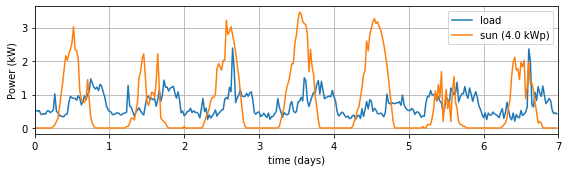

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,2.5))
z = slice(0, 7*48)
ax.plot(td[z], P_load.iloc[z], label='load', color='tab:blue')
ax.plot(td[z], P_sun.iloc[z], label='sun ({} kWp)'.format(P_pvp), color='tab:orange')

ax.legend()
ax.grid(True)

ax.set(
    xlim = (0,7),
    xlabel = 'time (days)',
    ylabel = 'Power (kW)'   
)
fig.tight_layout()

## 2. Rule based control

control rules:

* storage should follow the net load as much as possible: $P_{sto} = -P_{nl} = P_{sun} - P_{load} $
* if empty, use grid instead
* if full, curtail the excess of production

inputs: $P_{sun}$, $P_{load}$ and storage state $E_{sto}$

Outputs: $P_{sto}$, $P_{grid}$, $P_{curt}$

def: net load: $P_{nl} = P_{load} - P_{sun}$

* if $P_{nl}>0$ (load > sun)
  * if battery not empty: battery discharge to follow net load $P_{sto} = -P_{nl} <0 $, $P_{grid} = 0$.
  * if battery is empty, use the grid instead: $P_{grid} = P_{nl}$
* if $P_{nl}<0$ (sun > load)
  * if battery not full: battery charges to absorbe net production $P_{sto} = -P_{nl} > 0$, $P_{grid} = 0$.
  * if battery is full, curtail the excess of production: $P_{curt} = -P_{nl}$, so that $P_{sun} - P_{curt} = P_{pv} = P_{load}$. $P_{grid} = 0$

In [9]:
def control(P_sun, P_load, E_sto):
    P_nl = P_load - P_sun
    # outputs:
    P_sto = 0.
    P_grid = 0.
    P_curt = 0.
    
    E_next = E_sto - P_nl*dt
    
    if P_nl>0: # (load > sun)
        E_next = E_next if E_next>0. else 0.
        P_sto = (E_next - E_sto)/dt # <0
        P_grid = P_nl + P_sto
    else:
        E_next = E_next if E_next<E_rated else E_rated
        P_sto = (E_next - E_sto)/dt # >0
        P_curt = -P_nl - P_sto
    return P_sto, P_grid, P_curt

In [10]:
control(1,3, 5)

(-2.0, 0.0, 0.0)

In [11]:
control(1,3, 0)

(0.0, 2.0, 0.0)

In [12]:
control(1,3, 0.1*dt)

(-0.1, 1.9, 0.0)

In [13]:
control(3,1, 5)

(2.0, 0.0, 0.0)

In [14]:
control(3,1, E_rated)

(0.0, 0.0, 2.0)

In [15]:
control(3,1, E_rated-0.1*dt)

(0.09999999999999964, 0.0, 1.9000000000000004)

## 3. Solar home simulation

In [16]:
P_sto = np.zeros(n)
E_sto = np.zeros(n+1)
P_grid = np.zeros(n)
P_curt = np.zeros(n)

E_sto[0]= E_rated/2

for k in range(n):
    P_sto[k], P_grid[k], P_curt[k] = control(P_sun.values[k], P_load.values[k], E_sto[k])
    E_sto[k+1] = E_sto[k] + P_sto[k]*dt
    assert 0 <= E_sto[k+1] <= E_rated

    
E_sto = E_sto[:-1]
P_pv = P_sun - P_curt
P_nl = P_load - P_sun

Collect all trajectory variables

In [17]:
traj = pd.DataFrame(
    data = {
        'E_sto': E_sto, # state 
        'P_sto': P_sto, # out

        'P_load_sp': P_load,
        'P_shed': np.zeros_like(P_load),
        'P_load': P_load,

        'P_sun' : P_sun,
        'P_curt': P_curt,
        'P_pv'  : P_sun - P_curt,

        'P_grid': P_grid,
        'c_grid': c_grid,
    }, index=t
)
traj.index.name = 't'
traj.head(3)

,E_sto,P_sto,P_load_sp,P_shed,P_load,P_sun,P_curt,P_pv,P_grid,c_grid
t,,,,,,,,,,
0.0,4.000,-0.520,0.520,0.0,0.520,0.0,0.0,0.0,4.440892e-16,0.1
0.5,3.740,-0.528,0.528,0.0,0.528,0.0,0.0,0.0,-4.440892e-16,0.1
1.0,3.476,-0.496,0.496,0.0,0.496,0.0,0.0,0.0,-4.440892e-16,0.1


### Performance statistics

In [18]:
stats = bu.compute_stats(traj)
bu.pprint_stats(stats)

P_load:    17.02 kWh/d

P_sun:     15.60 kWh/d (data)
P_curt:     1.94 kWh/d
P_pv:      13.66 kWh/d

P_sto:      0.03 kWh/d

P_grid:     3.38 kWh/d
C_grid:    0.563 €/d



### Plots

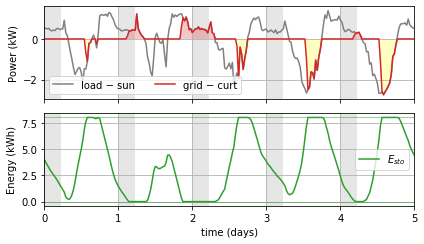

In [19]:
bu.plot_traj(traj[0:24*5], E_rated);

### Save results in CSV files

In [20]:
bu.save_results('Python_rule-based', params, stats, traj)

result files for method 'Python_rule-based' written!


## 4. Performance uncertainty evaluation with bootstrapped inputs

TO BE DONE:
1. add the ability to load boostrapped samples in `benchutils.load_data`)
2. put the simulation loop in a function